In [32]:
import os, re, json, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sklearn

In [33]:
warnings.filterwarnings("ignore", category=UserWarning)


In [34]:
df = pd.read_csv('house_rent_dataset.csv').copy()

In [35]:
def rmse_compat(y_true, y_pred):
    """Eski sklearn sürümlerinde squared=False yoksa RMSE'yi manuel hesaplar."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

In [36]:
def parse_floor_safe(s: str):
    """
    'Floor' metnini (örn: 'Ground out of 14', '3 out of 10', 'Upper Basement') iki sayıya çevirir.
    Dönüş: (current_floor, total_floors) — sayı yoksa NaN döner.
    """
    if pd.isna(s):
        return np.nan, np.nan

    s = str(s).strip().lower()
    parts = s.split("out of")
    cur_raw = parts[0].strip()
    tot_raw = parts[1].strip() if len(parts) > 1 else ""

    # current_floor
    if "ground" in cur_raw:
        cur_val = 0
    elif "upper" in cur_raw and "basement" in cur_raw:
        cur_val = -1
    elif "lower" in cur_raw and "basement" in cur_raw:
        cur_val = -2
    else:
        m = re.search(r"(\d+)", cur_raw)
        cur_val = int(m.group(1)) if m else np.nan

    # total_floors
    m2 = re.search(r"(\d+)", tot_raw)
    tot_val = int(m2.group(1)) if m2 else np.nan

    return cur_val, tot_val


In [37]:
def make_ohe_pipeline():
    """
    OneHotEncoder'ı sklearn sürümüne göre güvenli kur.
    1. Modern: sparse_output=False
    2. Eski:   sparse=False
    """
    try:
        return Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
    except TypeError:
        return Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
        ])

In [38]:
if "Floor" in df.columns:
    parsed = df["Floor"].apply(parse_floor_safe)
    df["current_floor"] = [p[0] for p in parsed]
    df["total_floors"]  = [p[1] for p in parsed]

# Çok yüksek kardinalite veya açıklama niteliğindeki kolonlar (varsa düş)
for col in ["Posted On", "Area Locality", "Point of Contact", "Floor"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)


In [39]:
target = "Rent"
assert target in df.columns, "Rent sütunu bulunamadı."

# Kritik sayısal kolonlarda çok eksik varsa satırı düş (eğitimi kolaylaştırır)
critical = [c for c in ["Size", "BHK", "Bathroom"] if c in df.columns]
if critical:
    before = len(df)
    df = df.dropna(subset=critical).copy()
    print(f"Kritik eksikler temizlendi: {before} → {len(df)}")

# Aşırı uçları yumuşat (Size)
if "Size" in df.columns:
    q1, q99 = df["Size"].quantile([0.01, 0.99])
    df["Size"] = df["Size"].clip(lower=q1, upper=q99)

Kritik eksikler temizlendi: 4746 → 4746


In [40]:
# Sayısal/kategorik listeleri çıkar (hedef hariç)
num_cols = [c for c in df.select_dtypes(include=np.number).columns if c != target]
cat_cols = list(df.select_dtypes(include="object").columns)

# X/y oluştur ve hizala
X = df[num_cols + cat_cols].replace([np.inf, -np.inf], np.nan)
y = df[target].replace([np.inf, -np.inf], np.nan)
mask = (~y.isna())
X, y = X.loc[mask], y.loc[mask]

print(f"Features -> numeric: {len(num_cols)}, categorical: {len(cat_cols)}")
print("X shape:", X.shape, "| y shape:", y.shape)

Features -> numeric: 5, categorical: 4
X shape: (4746, 9) | y shape: (4746,)


In [41]:
#  Hedefi log'a almak )
use_log_target = True
y_target = np.log1p(y) if use_log_target else y


In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, random_state=42
)

In [43]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = make_ohe_pipeline()

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


In [44]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
}

results = {}
fitted = {}

for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Değerlendirmeyi gerçek para ölçeğine çevir
    y_test_real = np.expm1(y_test) if use_log_target else y_test
    y_pred_real = np.expm1(y_pred) if use_log_target else y_pred

    r2   = r2_score(y_test_real, y_pred_real)
    rmse = rmse_compat(y_test_real, y_pred_real)
    mae  = mean_absolute_error(y_test_real, y_pred_real)

    results[name] = {"R2": float(r2), "RMSE": float(rmse), "MAE": float(mae)}
    fitted[name] = pipe

    print(f"{name:16s} -> R2: {r2:.3f} | RMSE: {rmse:.1f} | MAE: {mae:.1f}")


LinearRegression -> R2: 0.616 | RMSE: 39115.7 | MAE: 12272.1
RandomForest     -> R2: 0.683 | RMSE: 35554.5 | MAE: 10981.0


In [45]:
best = max(results, key=lambda k: results[k]["R2"])
print("\nBest model:", best, results[best])

out_dir = "../model"
os.makedirs(out_dir, exist_ok=True)

# Pipeline + meta yaz
from joblib import dump
model_path = os.path.join(out_dir, "house_rent_model.joblib")
dump(fitted[best], model_path)

meta = {
    "use_log_target": use_log_target,
    "target": target,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "sklearn_version": sklearn.__version__,
}
with open(os.path.join(out_dir, "model_meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"✅ Model kaydedildi: {model_path}")
print(f"✅ Meta yazıldı   : {os.path.join(out_dir, 'model_meta.json')}")


Best model: RandomForest {'R2': 0.682810533331963, 'RMSE': 35554.47896486353, 'MAE': 10980.970658167033}
✅ Model kaydedildi: ../model/house_rent_model.joblib
✅ Meta yazıldı   : ../model/model_meta.json


In [46]:
import json, numpy as np, pandas as pd
from joblib import load
from pathlib import Path

# Kayıt konumu: eğitim çıktısında yazan klasörü kullan
MODEL_DIR = Path("../model")  # gerekirse "./model" yap
pipe = load(MODEL_DIR / "house_rent_model.joblib")

with open(MODEL_DIR / "model_meta.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

use_log_target = bool(meta["use_log_target"])
num_cols = meta["num_cols"]
cat_cols = meta["cat_cols"]

# ÖRNEK GİRDİ (kendi değerlerinle değiştir)
sample = {
    "Size": 1100,
    "BHK": 2,
    "Bathroom": 2,
    "City": "Bangalore",
    "Area Type": "Super Area",
    "Furnishing Status": "Semi-Furnished",
    "Tenant Preferred": "Bachelors/Family",
    "current_floor": 3,
    "total_floors": 10,
}

# Eksik kolonları np.nan ile doldurup doğru sırayla DataFrame oluştur
row = {}
for c in num_cols + cat_cols:
    row[c] = sample.get(c, np.nan)

X_one = pd.DataFrame([row])
pred = pipe.predict(X_one)[0]
pred_real = float(np.expm1(pred) if use_log_target else pred)

print("🔮 Tahmin (₹):", round(pred_real))

🔮 Tahmin (₹): 20417


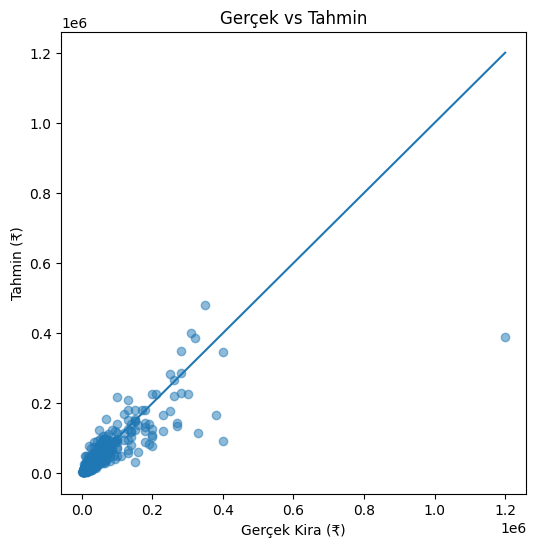

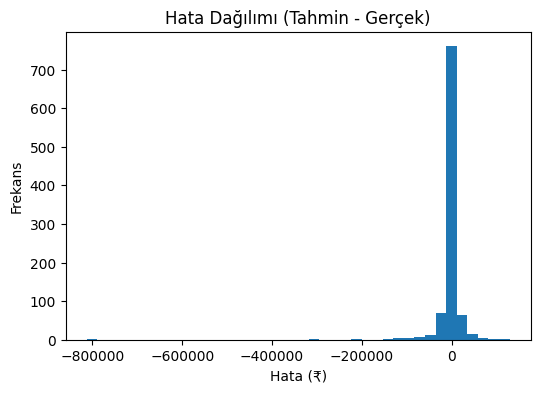

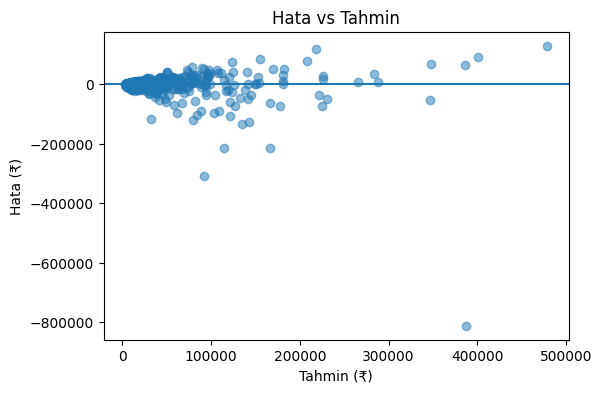

R2≈ 0.683 | RMSE≈ 35,554 | MAE≈ 10,981


In [47]:
# --- DIAGNOSTIC PLOTS (matplotlib) ---
import numpy as np
import matplotlib.pyplot as plt

# Kaydedilmiş modeli ve metayı yükle
def load_model_and_meta(model_dir="../model"):
    from joblib import load
    import json
    from pathlib import Path
    p = Path(model_dir)
    pipe = load(p / "house_rent_model.joblib")
    meta = json.load(open(p / "model_meta.json", "r", encoding="utf-8"))
    return pipe, meta

# Y-true ve Y-hat üret (eğitimden kalan X_test/y_test varsa onları kullan, yoksa dataset’ten üret)
def get_y_true_pred(pipe, meta, X_test=None, y_test=None, df_path="house_rent_dataset.csv"):
    use_log_target = bool(meta["use_log_target"])
    if X_test is not None and y_test is not None:
        y_true = np.expm1(y_test) if use_log_target else y_test
        y_pred = pipe.predict(X_test)
        y_hat  = np.expm1(y_pred) if use_log_target else y_pred
        return np.asarray(y_true), np.asarray(y_hat)
    else:
        import pandas as pd
        num_cols, cat_cols = meta["num_cols"], meta["cat_cols"]
        target = meta.get("target", "Rent")
        df = pd.read_csv(df_path)
        X_full = df[num_cols + cat_cols]
        y_true = df[target].values
        y_pred = pipe.predict(X_full)
        y_hat  = np.expm1(y_pred) if use_log_target else y_pred
        return np.asarray(y_true), np.asarray(y_hat)

pipe, meta = load_model_and_meta("../model")

# Eğitim oturumu açıksa X_test/y_test kullan; değilse dataset’ten hesapla
try:
    y_true, y_hat = get_y_true_pred(pipe, meta, X_test=X_test, y_test=y_test)
except NameError:
    y_true, y_hat = get_y_true_pred(pipe, meta)

# 1) Gerçek vs Tahmin (45° referans çizgisiyle)
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_hat, alpha=0.5)
lo = float(min(np.min(y_true), np.min(y_hat)))
hi = float(max(np.max(y_true), np.max(y_hat)))
plt.plot([lo, hi], [lo, hi])
plt.title("Gerçek vs Tahmin")
plt.xlabel("Gerçek Kira (₹)")
plt.ylabel("Tahmin (₹)")
plt.show()

# 2) Hata histogramı (residual)
res = y_hat - y_true
plt.figure(figsize=(6,4))
plt.hist(res, bins=40)
plt.title("Hata Dağılımı (Tahmin - Gerçek)")
plt.xlabel("Hata (₹)")
plt.ylabel("Frekans")
plt.show()

# 3) Hata vs Tahmin (trend/heteroskedastisite kontrolü)
plt.figure(figsize=(6,4))
plt.scatter(y_hat, res, alpha=0.5)
plt.axhline(0)
plt.title("Hata vs Tahmin")
plt.xlabel("Tahmin (₹)")
plt.ylabel("Hata (₹)")
plt.show()

# Özet metrikler (burada tekrar hesap)
rmse = float(np.sqrt(np.mean((y_hat - y_true)**2)))
mae  = float(np.mean(np.abs(y_hat - y_true)))
from sklearn.metrics import r2_score
r2   = float(r2_score(y_true, y_hat))
print(f"R2≈ {r2:.3f} | RMSE≈ {rmse:,.0f} | MAE≈ {mae:,.0f}")


In [48]:
import pandas as pd, numpy as np, json
from joblib import load
from pathlib import Path

# Şehir medyanlarını çıkar
df = pd.read_csv("house_rent_dataset.csv")
city_medians = df.groupby("City")["Rent"].median().sort_values(ascending=False)
print("Şehir medyanları (ilk 10):")
print(city_medians.head(10))

# Modeli ve meta bilgiyi yükle
MODEL_DIR = Path("../model")   # modeli nereye kaydettiysen ona göre değiştir
pipe = load(MODEL_DIR / "house_rent_model.joblib")
meta = json.load(open(MODEL_DIR / "model_meta.json","r",encoding="utf-8"))
use_log_target = bool(meta["use_log_target"])
num_cols, cat_cols = meta["num_cols"], meta["cat_cols"]

# ÖRNEK GİRDİ (kendi değerlerinle değiştir)
sample = {
    "Size": 1100, "BHK": 2, "Bathroom": 2,
    "City": "Bangalore", "Area Type": "Super Area",
    "Furnishing Status": "Semi-Furnished",
    "Tenant Preferred": "Bachelors/Family",
    "current_floor": 3, "total_floors": 10
}

# Tek satır tahmin
row = {c: sample.get(c, np.nan) for c in (num_cols + cat_cols)}
X_one = pd.DataFrame([row])
pred = pipe.predict(X_one)[0]
pred_real = float(np.expm1(pred) if use_log_target else pred)

city_med = float(city_medians.get(sample["City"], np.nan))

print(f"\nTahminin (₹): {round(pred_real):,}")
if not np.isnan(city_med):
    print(f"{sample['City']} median (₹): {round(city_med):,}")
    diff_pct = (pred_real - city_med) / city_med * 100
    print(f"Mediana göre fark: {diff_pct:+.1f}%")
else:
    print(f"{sample['City']} için medyan bulunamadı.")


Şehir medyanları (ilk 10):
City
Mumbai       52000.0
Delhi        17000.0
Bangalore    14000.0
Chennai      14000.0
Hyderabad    14000.0
Kolkata       8500.0
Name: Rent, dtype: float64

Tahminin (₹): 20,417
Bangalore median (₹): 14,000
Mediana göre fark: +45.8%
